In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
cd "/content/drive/MyDrive/Transliteration"

/content/drive/MyDrive/Transliteration


In [6]:
ls

Gidugu.ttf   hindi.ttf     hin_train.tsv  train.tsv
hin_dev.tsv  hin_test.tsv  test.tsv       valid.tsv


In [7]:
import numpy as np
import tensorflow as tf
from random import randint
import matplotlib.pyplot as plt
from numpy import array,argmax,array_equal
import keras.backend as K
from tensorflow.keras import models,Input
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import LSTM, Bidirectional, SimpleRNN, GRU,Lambda,Dense, Flatten
from tensorflow.keras.optimizers import Adam
import matplotlib.ticker as ticker
tf.keras.backend.set_floatx('float64')
from tensorflow.keras.layers import TimeDistributed,RepeatVector
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.font_manager import FontProperties
import csv

In [8]:
import imageio
import os
from tqdm import tqdm_notebook as tqdm
from PIL import Image
from IPython.display import HTML as html_print
from IPython.display import display

In [9]:
train_dir = "train.tsv"
valid_dir = "valid.tsv"
test_dir  = "test.tsv"
# train_dir = "hin_train.tsv"
# valid_dir = "hin_dev.tsv"
# test_dir  = "hin_test.tsv"

In [10]:
telugu_font = FontProperties(fname='Gidugu.ttf')

In [11]:
telugu_font

In [12]:
import io
def getCorpus(crp):
  Eng = []
  Telugu= []

  with io.open(crp, encoding ='utf-8') as f:
    for line in f:
      if '\t' not in line:
        continue
      tokens = line.rstrip().split("\t")
      Eng.append(tokens[1])
      Telugu.append(tokens[0])

  return Eng, Telugu

In [13]:
trainSrc, trainTgt = getCorpus(train_dir)
validSrc, validTgt = getCorpus(valid_dir)
testSrc, testTgt = getCorpus(test_dir)

print("Training examples: ", len(trainSrc))
print("Validation examples: ", len(validSrc))
print("Testing examples: ", len(testSrc))

Training examples:  58550
Validation examples:  5683
Testing examples:  5747


In [14]:
#Shuffling the Training and Validation dataset

trainArr = np.arange(len(trainSrc))
np.random.shuffle(trainArr)
validArr = np.arange(len(validSrc))
np.random.shuffle(validArr)

In [15]:
sourceCharacters = set()
targetCharacters = set()

sourceWords=[]
targetWords=[]

valSrcWords=[]
valTgtWords=[]

for i in trainArr:
  txt_tgt = 'B'+trainTgt[i]+'E'
  txt_src = trainSrc[i]
  for chr in txt_src:
    if chr not in sourceCharacters:
      sourceCharacters.add(chr)
  for chr in txt_tgt:
    if chr not in targetCharacters:
      targetCharacters.add(chr)
  sourceWords.append(txt_src)
  targetWords.append(txt_tgt)


for i in validArr:
  txt_tgt = 'B'+validTgt[i]+'E'
  txt_src = validSrc[i]
  for chr in txt_src:
    if chr not in sourceCharacters:
      sourceCharacters.add(chr)
  for chr in txt_tgt:
    if chr not in targetCharacters:
      targetCharacters.add(chr)
  valSrcWords.append(txt_src)
  valTgtWords.append(txt_tgt)

sourceCharacters.add(" ")
targetCharacters.add(" ")

sourceCharacters=sorted(list(sourceCharacters))
targetCharacters=sorted(list(targetCharacters))




In [16]:
print(sourceCharacters)
print(targetCharacters)

[' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
[' ', 'B', 'E', 'ం', 'ః', 'అ', 'ఆ', 'ఇ', 'ఈ', 'ఉ', 'ఊ', 'ఋ', 'ఎ', 'ఏ', 'ఐ', 'ఒ', 'ఓ', 'ఔ', 'క', 'ఖ', 'గ', 'ఘ', 'చ', 'ఛ', 'జ', 'ఝ', 'ఞ', 'ట', 'ఠ', 'డ', 'ఢ', 'ణ', 'త', 'థ', 'ద', 'ధ', 'న', 'ప', 'ఫ', 'బ', 'భ', 'మ', 'య', 'ర', 'ఱ', 'ల', 'ళ', 'వ', 'శ', 'ష', 'స', 'హ', 'ా', 'ి', 'ీ', 'ు', 'ూ', 'ృ', 'ె', 'ే', 'ై', 'ొ', 'ో', 'ౌ', '్', '\u200c']


In [17]:
enc_tokens = len(sourceCharacters)
dec_tokens = len(targetCharacters)

max_enc_seq_length = max([len(txt) for txt in sourceWords])
max_dec_seq_length = max([len(txt) for txt in targetWords])

val_max_enc_seq_length = max([len(txt) for txt in valSrcWords])
val_max_dec_seq_length = max([len(txt) for txt in valTgtWords])

print("Number of samples:", len(sourceWords))
print("Number of unique input tokens:", enc_tokens)
print("Number of unique output tokens:", dec_tokens)
print("Max sequence length for inputs:", max_enc_seq_length)
print("Max sequence length for outputs:", max_dec_seq_length)
print("Max sequence length for val inputs:", val_max_enc_seq_length)
print("Max sequence length for val outputs:", val_max_dec_seq_length)

Number of samples: 58550
Number of unique input tokens: 27
Number of unique output tokens: 66
Max sequence length for inputs: 25
Max sequence length for outputs: 22
Max sequence length for val inputs: 21
Max sequence length for val outputs: 21


In [18]:
print(sourceWords[10:20])
print(targetWords[10:20])

['gudiki', 'premiier', 'irukkumdi', 'avagatam', 'rassel', 'haristundi', 'puttagodugula', 'amdimchaadu', 'paarliaament', 'krushnaarao']
['BగుడికిE', 'Bప్రీమియర్E', 'Bఇరుక్కుందిE', 'BఅవగతంE', 'Bరస్సెల్E', 'Bహరిస్తుందిE', 'Bపుట్టగొడుగులE', 'BఅందించాడుE', 'Bపార్లమెంట్E', 'Bకృష్ణారావుE']


In [19]:
srcIndex = dict([(char, i) for i, char in enumerate(sourceCharacters)])
tgtIndex = dict([(char, i) for i, char in enumerate(targetCharacters)])

print(srcIndex)
print(tgtIndex)

{' ': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
{' ': 0, 'B': 1, 'E': 2, 'ం': 3, 'ః': 4, 'అ': 5, 'ఆ': 6, 'ఇ': 7, 'ఈ': 8, 'ఉ': 9, 'ఊ': 10, 'ఋ': 11, 'ఎ': 12, 'ఏ': 13, 'ఐ': 14, 'ఒ': 15, 'ఓ': 16, 'ఔ': 17, 'క': 18, 'ఖ': 19, 'గ': 20, 'ఘ': 21, 'చ': 22, 'ఛ': 23, 'జ': 24, 'ఝ': 25, 'ఞ': 26, 'ట': 27, 'ఠ': 28, 'డ': 29, 'ఢ': 30, 'ణ': 31, 'త': 32, 'థ': 33, 'ద': 34, 'ధ': 35, 'న': 36, 'ప': 37, 'ఫ': 38, 'బ': 39, 'భ': 40, 'మ': 41, 'య': 42, 'ర': 43, 'ఱ': 44, 'ల': 45, 'ళ': 46, 'వ': 47, 'శ': 48, 'ష': 49, 'స': 50, 'హ': 51, 'ా': 52, 'ి': 53, 'ీ': 54, 'ు': 55, 'ూ': 56, 'ృ': 57, 'ె': 58, 'ే': 59, 'ై': 60, 'ొ': 61, 'ో': 62, 'ౌ': 63, '్': 64, '\u200c': 65}


In [20]:
revSrcIndex = dict((i, char) for  char,i in srcIndex.items())
revTgtIndex = dict((i, char) for  char,i in tgtIndex.items())

print(revSrcIndex)
print(revTgtIndex)

{0: ' ', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}
{0: ' ', 1: 'B', 2: 'E', 3: 'ం', 4: 'ః', 5: 'అ', 6: 'ఆ', 7: 'ఇ', 8: 'ఈ', 9: 'ఉ', 10: 'ఊ', 11: 'ఋ', 12: 'ఎ', 13: 'ఏ', 14: 'ఐ', 15: 'ఒ', 16: 'ఓ', 17: 'ఔ', 18: 'క', 19: 'ఖ', 20: 'గ', 21: 'ఘ', 22: 'చ', 23: 'ఛ', 24: 'జ', 25: 'ఝ', 26: 'ఞ', 27: 'ట', 28: 'ఠ', 29: 'డ', 30: 'ఢ', 31: 'ణ', 32: 'త', 33: 'థ', 34: 'ద', 35: 'ధ', 36: 'న', 37: 'ప', 38: 'ఫ', 39: 'బ', 40: 'భ', 41: 'మ', 42: 'య', 43: 'ర', 44: 'ఱ', 45: 'ల', 46: 'ళ', 47: 'వ', 48: 'శ', 49: 'ష', 50: 'స', 51: 'హ', 52: 'ా', 53: 'ి', 54: 'ీ', 55: 'ు', 56: 'ూ', 57: 'ృ', 58: 'ె', 59: 'ే', 60: 'ై', 61: 'ొ', 62: 'ో', 63: 'ౌ', 64: '్', 65: '\u200c'}


In [21]:
encSrc = np.zeros((len(sourceWords), max_enc_seq_length,enc_tokens), dtype="float32")
decTgt = np.zeros((len(sourceWords), max_dec_seq_length, dec_tokens), dtype="float32")
valEncSrc = np.zeros((len(valSrcWords), max_enc_seq_length,enc_tokens), dtype="float32")
valDecTgt = np.zeros((len(valSrcWords), max_dec_seq_length, dec_tokens), dtype="float32")

for i, (txt_ip, txt_tgt) in enumerate(zip(sourceWords, targetWords)):
    for t, char in enumerate(txt_ip):
        encSrc[i, t ,srcIndex[char]] = 1.0
    encSrc[i, t + 1 :,srcIndex[" "]] = 1.0
    for t, char in enumerate(txt_tgt):
          decTgt[i, t, tgtIndex[char]] = 1.0
    decTgt[i, t:+1, tgtIndex[" "]] = 1.0

for i, (txt_ip, txt_tgt) in enumerate(zip(valSrcWords, valTgtWords)):
    for t, char in enumerate(txt_ip):
        valEncSrc[i, t,srcIndex[char]] = 1.0
    valEncSrc[i, t + 1 :,srcIndex[" "]] = 1.0
    for t, char in enumerate(txt_tgt):
        valDecTgt[i, t, tgtIndex[char]] = 1.0
    valDecTgt[i, t+1:, tgtIndex[" "]] = 1.0



In [22]:
class Attention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(Attention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, value):

    query_with_time_axis = tf.expand_dims(query, 1)

    score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(value)))

    aw = tf.nn.softmax(score, axis=1)
    vc = aw * value
    vc = tf.reduce_sum(vc, axis=1)

    return vc, aw



In [33]:
class Seq_to_Seq_with_attention(object):

  def __init__(self, cell = 'RNN', hidden_layer=32, learning_rate= 1e-3, drop_out = 0.3,
               epochs = 10, batch_size = 32, attention = 'bahdanau'):

    self.cell = cell
    self.hidden_layer = hidden_layer
    self.learning_rate = learning_rate
    self.drop_out = drop_out
    self.epochs = epochs
    self.batch_size = batch_size
    self.attention = attention

  def fit_model(self, ip_encd, tgt_decd):

    ip_encds = Input(shape=(max_enc_seq_length, enc_tokens), name='enc_inputs')

    if self.cell == 'LSTM':

      enc_lstm = LSTM(self.hidden_layer,return_sequences=True, return_state=True, dropout = self.drop_out, name='enc_lstm')
      enc_ops, enc_hs, enc_cs = enc_lstm(ip_encds)
      states_enc = [enc_hs, enc_cs]

    elif self.cell == 'RNN':

      enc_rnn = SimpleRNN(self.hidden_layer,return_sequences=True, return_state=True, dropout = self.drop_out, name='enc_rnn')
      enc_ops, enc_hs = enc_rnn(ip_encds)
      states_enc = [enc_hs]

    elif self.cell == 'GRU':

      enc_gru = GRU(self.hidden_layer,return_sequences=True, return_state=True, dropout = self.drop_out, name='enc_gru')
      enc_ops, enc_hs = enc_gru(ip_encds)
      states_enc = [enc_hs]



    # Attention Layer
    if self.attention == 'bahdanau':
      attention= Attention(self.hidden_layer)

    # dec Layers
    inps_deco = Input(shape=(1, (dec_tokens + self.hidden_layer)),name='dec_inputs')

    if self.cell == 'LSTM':

      dec_lstm = LSTM(self.hidden_layer, dropout = self.drop_out, return_state=True, name='dec_lstm')

    elif self.cell == 'GRU':

      dec_gru = GRU(self.hidden_layer, dropout = self.drop_out, return_state=True, name='dec_gru')

    elif self.cell == 'RNN':

      dec_rnn = SimpleRNN(self.hidden_layer, dropout = self.drop_out, return_state=True, name='dec_rnn')


    dec_dense = Dense(dec_tokens, activation='softmax',  name='dec_dense')
    all_ops = []

    ips = np.zeros((self.batch_size, 1, dec_tokens))
    ips[:, 0, 0] = 1

    dec_ops = enc_hs
    states = states_enc

    for _ in range(max_dec_seq_length):

      vc, aw = attention(dec_ops, enc_ops)
      vc = tf.expand_dims(vc, 1)

      ips = tf.concat([vc, ips], axis=-1)

      if self.cell == 'LSTM':

        dec_ops, hs, cs = dec_lstm(ips, initial_state=states)

      if self.cell == 'GRU':

        dec_ops, hs = dec_gru(ips, initial_state=states)

      if self.cell == 'RNN':

        dec_ops, hs = dec_rnn(ips, initial_state=states)

      ops = dec_dense(dec_ops)
      ops = tf.expand_dims(ops, 1)
      all_ops.append(ops)
      ips = ops
      if self.cell == 'LSTM':

        states = [hs, cs]

      if self.cell == 'GRU' or self.cell == 'RNN':

        states = [hs]


    dec_ops = Lambda(lambda x: K.concatenate(x, axis=1))(all_ops)
    model = Model(ip_encds, dec_ops, name='model_enc_dec')

    optimizer = Adam(lr=self.learning_rate, beta_1=0.9, beta_2=0.999)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit(ip_encd, tgt_decd,
              batch_size=self.batch_size,
              epochs=self.epochs,
              #callbacks = [WandbCallback()]
              )

    if self.cell == 'LSTM':
      return enc_lstm,attention,dec_lstm,dec_dense
    if self.cell == 'GRU':
      return enc_gru,attention,dec_gru,dec_dense
    if self.cell == 'RNN':
      return enc_rnn,attention,dec_rnn,dec_dense

  def evaluate(self,seq_in):
    attention_plot = np.zeros((max_dec_seq_length, max_enc_seq_length))

    sequence = seq_in

    enc_inputs=array(sequence).reshape(1,max_enc_seq_length,enc_tokens)

    enc_inputs = tf.convert_to_tensor(enc_inputs,dtype=tf.float32)

    if self.cell == 'LSTM':

      enc_outputs, enc_state_h, enc_state_c = encoder(enc_inputs)
      enc_states = [enc_state_h, enc_state_c]
    elif self.cell == 'GRU':
      enc_outputs, enc_state_h = encoder(enc_inputs)
      enc_states = [enc_state_h]

    elif self.cell == 'RNN':

      enc_outputs, enc_state_h = encoder(enc_inputs)
      enc_states = [enc_state_h]

    all_outputs = []

    dec_input_data = np.zeros((1, 1, dec_tokens))
    dec_input_data[:, 0, 0] = 1

    inputs = dec_input_data
    dec_outputs = enc_state_h
    states = enc_states

    weigh_atten =[]
    for t in range(max_dec_seq_length):

      # pay attention
      context_vector, attention_weights=attention(dec_outputs, enc_outputs)

      # storing the attention weights to plot later on
      attention_weights = tf.reshape(attention_weights, (-1, ))
      weigh_atten.append(attention_weights)

      attention_plot[t] = attention_weights.numpy()

      dec_outputs=tf.expand_dims(dec_outputs, 1)

      context_vector = tf.expand_dims(context_vector, 1)
      inputs = tf.concat([context_vector, inputs], axis=-1)

      if self.cell == 'LSTM':
        dec_outputs, state_h, state_c = decoder(inputs, initial_state=states)
      if self.cell == 'GRU':
        dec_outputs, state_h = decoder(inputs, initial_state=states)
      if self.cell == 'RNN':
        dec_outputs, state_h = decoder(inputs, initial_state=states)

      outputs = decoder_dense(dec_outputs)
      # Store the current prediction (we will concatenate all predictions later)
      outputs = tf.expand_dims(outputs, 1)
      all_outputs.append(outputs)
      inputs = outputs
      if self.cell == 'LSTM':
        states = [state_h, state_c]
      if self.cell == 'GRU' or self.cell == 'RNN':
        states = [state_h]

    dec_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)
    seq_outs = dec_outputs[0]
    seq_out = tf.argmax(seq_outs, axis=1)
    seq_out = seq_out.numpy()
    seq_in = tf.argmax(seq_in, axis = 1)
    seq_in = seq_in.numpy()
    list(filter(lambda num: num != 0, seq_in))
    list(filter(lambda num: num != 0, seq_out))

    return seq_in, seq_out, attention_plot, weigh_atten

  def plot_attention(self,attention, sequence, predicted_sequence, idx,fig):

    ax = fig.add_subplot(4, 3, idx)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 16}
    seq = ''
    for i in range(len(sequence)):
      seq = seq + revSrcIndex[sequence[i]]

    pred = ''
    for i in range(len(predicted_sequence)):
      pred = pred + revTgtIndex[predicted_sequence[i]]
    true_pred =''
    for i in pred:
      if i=='E' or i=='B':
        continue
      true_pred=true_pred+i

    print(seq + " : " + true_pred)

    ax.set_xticklabels(seq, fontdict=fontdict)
    ax.set_yticklabels(pred, fontdict=fontdict,fontproperties =telugu_font)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))


  def translate(self,seq_in, idx,fig):
    seq_in, seq_out, attention_plot, weigh_atten = self.evaluate(seq_in)

    a = [0]
    for i in range(len(seq_in)):
      if seq_in[i] != 0:
        a.append(seq_in[i])

    b = []
    for i in range(len(seq_out)):
      if seq_out[i] != 0:
        b.append(seq_out[i])

    b = b[:len(b)-1]


    attention_plot = attention_plot[:len(b), :len(a)]
    self.plot_attention(attention_plot, a, b, idx,fig)

    return weigh_atten

  def attention_plot(self,val_input):
    aw = []
    fig = plt.figure(figsize=(16,18))
    for i in range(1,13,1):
      seq_in = val_input[i*9]
      weigh_atten = self.translate(seq_in,i,fig)
      aw.append(weigh_atten)
    plt.show()
    return aw

In [24]:
rnn_model = Seq_to_Seq_with_attention(cell = 'LSTM', hidden_layer=256, learning_rate= 1e-3,
                        drop_out=0.2,epochs = 7, batch_size = 128, attention = 'bahdanau')

In [25]:
encoder,attention,decoder,decoder_dense = rnn_model.fit_model(encSrc[:58496],decTgt[:58496])


Epoch 1/7
457/457 [==============================] - 962s 2s/step - loss: 1.1676 - accuracy: 0.1357
Epoch 2/7
457/457 [==============================] - 949s 2s/step - loss: 0.8514 - accuracy: 0.2011
Epoch 3/7
457/457 [==============================] - 947s 2s/step - loss: 0.6704 - accuracy: 0.2497
Epoch 4/7
457/457 [==============================] - 949s 2s/step - loss: 0.5861 - accuracy: 0.2744
Epoch 5/7
457/457 [==============================] - 941s 2s/step - loss: 0.5343 - accuracy: 0.2911
Epoch 6/7
457/457 [==============================] - 941s 2s/step - loss: 0.4976 - accuracy: 0.3027
Epoch 7/7
457/457 [==============================] - 942s 2s/step - loss: 0.4744 - accuracy: 0.3091


In [26]:
print(valEncSrc[0].shape)

(25, 27)


 yasidlu : BయసిిడలుEEEEEEEEEEEEE


<ipython-input-23-8c4759a1290d>:210: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(seq, fontdict=fontdict)
<ipython-input-23-8c4759a1290d>:211: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(pred, fontdict=fontdict,fontproperties =telugu_font)


 sanghamunaku : BసంఘమునకుEEEEEEEEEEEE
 nirmoolinchadam : Bనిర్మోనించంEEEEEEEEE
 thuragaa : BతురగాEEEEEEEEEEEEEEE
 mahanubhavudi : BమహనుభాుుEEEEEEEEEEEE
 praadhamika : Bప్రాధంికEEEEEEEEEEEE
 kaaryanirvahaka : Bకార్యనిర్వాEEEEEEEEE
 lebul : Bలెబుల్EEEEEEEEEEEEEE
 dasaabdamloo : Bదశాబ్ధంలోEEEEEEEEEEE
 kiranhaalanu : BకిరణాలనుEEEEEEEEEEEE
 pikkalanu : Bపిక్లలుEEEEEEEEEEEEE
 suchistunnaru : Bసూచిస్తున్నారుEEEEEE


ValueError: ignored

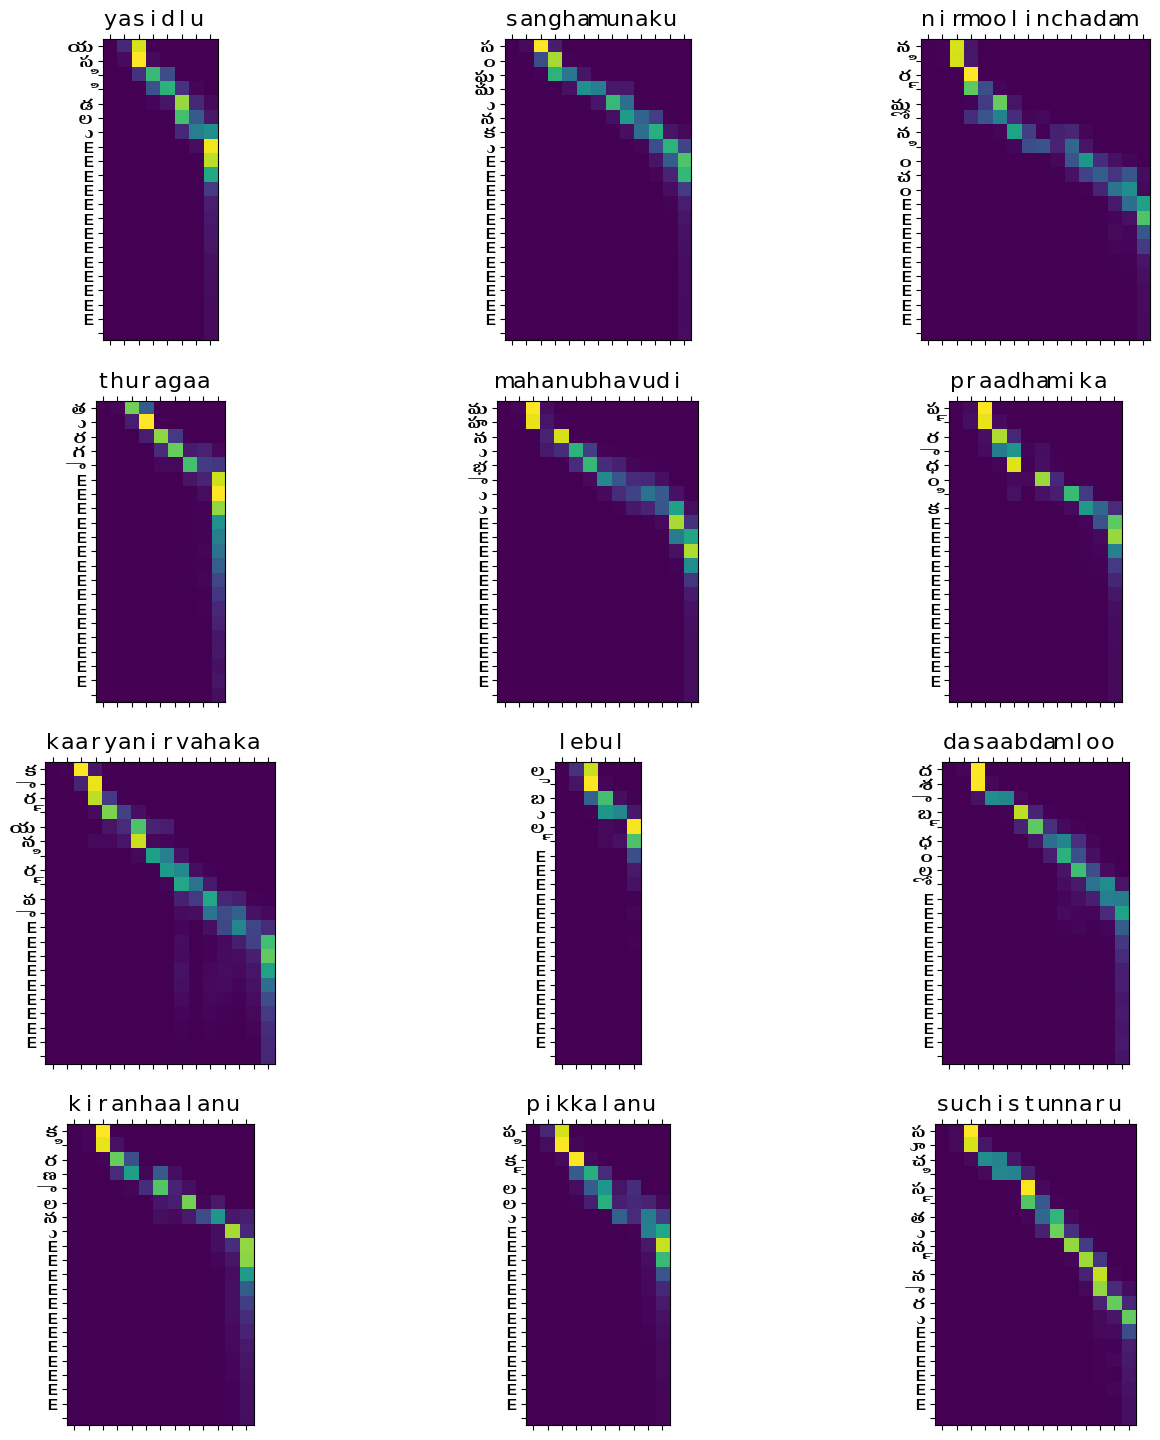

In [36]:
w_a = rnn_model.attention_plot(valEncSrc[200:])